# Look at the himawari-8 AHI raw data from NCI

From Kurihara et al., 2016: IR bands centered at 3.9, 8.6, 10.4, 11.2, and 12.4 μm

- 8.6 um = Band 11
- 10.4 = Band 13


NCI opendap data catalog example:

http://dapds00.nci.org.au/thredds/rr5/satellite/obs/himawari8/FLDK/2020/02/07/0400/catalog.html

!pip install --user xarray netcdf4 h5netcdf

In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp2d
from pyproj import Proj
import cmocean as cm

#!pip install xmovie
from xmovie import Movie

In [12]:
%matplotlib inline

In [13]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14


# Open multiple opendap files

See:
    https://rabernat.github.io/research_computing_2018/xarray-tips-and-triinterp2d
    
    

In [14]:
def get_himawari9_url(band, yyyy, mm, dd, hhmm):
    yyyy = f"{int(yyyy):04d}"; mm = f"{int(mm):02d}"; dd = f"{int(dd):02d}"; hhmm = f"{int(hhmm):04d}"
    # 用归档集合（arc）+ 新域名
    base = "https://thredds.nci.org.au/thredds/dodsC/ra22/satellite-products/arc/obs/himawari-ahi/fldk/v1-0/"
    # 注意文件名里含分辨率（这里是 2000，对 B14 正常）
    fname = f"{yyyy}{mm}{dd}{hhmm}00-P1S-ABOM_OBS_B{band}-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc"
    return f"{base}{yyyy}/{mm}/{dd}/{hhmm}/{fname}"


In [ ]:
# ==== 改这里：时间窗、标签、范围、波段 ====
t1 = '2025-01-15 00:00:00'
t2 = '2025-01-15 06:00:00'
date = '20250115'   # 电影/输出标签

lon1, lon2 = 111, 114
lat1, lat2 = -25, -20

channel = 14
vmin, vmax = 21, 24
# ========================================

times = pd.date_range(t1, t2, freq='600s')  # 用小写 s
urls = []
for tt in times:
    hhmm = f'{tt.hour:02d}{tt.minute:02d}'
    urls.append(get_himawari9_url(channel, tt.year, f'{tt.month:02d}', f'{tt.day:02d}', hhmm))


In [16]:
import requests

def check_dds(url):
    try:
        r = requests.get(url + '.dds', timeout=20, allow_redirects=False)
        print(r.status_code, url)  # 观察是否 302/401/403
        return r.status_code in (200, 302)
    except Exception:
        return False

test_urls = urls[:5]
goodurl = [u for u in urls if check_dds(u)]
print("可用文件数：", len(goodurl))


200 https://thredds.nci.org.au/thredds/dodsC/ra22/satellite-products/arc/obs/himawari-ahi/fldk/v1-0/2025/01/15/0000/20250115000000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
200 https://thredds.nci.org.au/thredds/dodsC/ra22/satellite-products/arc/obs/himawari-ahi/fldk/v1-0/2025/01/15/0010/20250115001000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
200 https://thredds.nci.org.au/thredds/dodsC/ra22/satellite-products/arc/obs/himawari-ahi/fldk/v1-0/2025/01/15/0020/20250115002000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
200 https://thredds.nci.org.au/thredds/dodsC/ra22/satellite-products/arc/obs/himawari-ahi/fldk/v1-0/2025/01/15/0030/20250115003000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
200 https://thredds.nci.org.au/thredds/dodsC/ra22/satellite-products/arc/obs/himawari-ahi/fldk/v1-0/2025/01/15/0040/20250115004000-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc
200 https://thredds.nci.org.au/thredds/dodsC/ra22/satellite-products/arc/obs/himawari-ahi/

In [17]:
len(goodurl)

36

In [18]:
dsmf = xr.open_mfdataset(goodurl)
dsmf

<xarray.Dataset> Size: 4GB
Dimensions:                              (time: 36, y: 5500, x: 5500)
Coordinates:
  * time                                 (time) datetime64[ns] 288B 2025-01-1...
  * x                                    (x) float64 44kB -5.499e+06 ... 5.49...
  * y                                    (y) float64 44kB 5.499e+06 ... -5.49...
Data variables:
    geostationary                        (time) float32 144B 9.969e+36 ... 9....
    scan_line_time                       (time, y) datetime64[ns] 2MB dask.array<chunksize=(1, 5500), meta=np.ndarray>
    channel_0014_brightness_temperature  (time, y, x) float32 4GB dask.array<chunksize=(1, 5500, 5500), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  See disclaimer
    cdm_data_type:                   grid
    comment:                         AGLS observations geometry product
    contributor_name:                Commonwealth of Australia, Bureau of Met...
    ...                              ...
    time_coverage_start:             20250115T000021Z
    wmo_platform_name:               Himawari-9
    wmo_satellite_number:            174
    history:                         Thu Feb 20 23:48:25 2025: ncatted -O -a ...
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    product_version:                 1.0

In [19]:
# Subset the data
#
# 1) Reproject the lat/lon bounds to grid project
# 2) Find the grid i/j points
# 3) 

X,Y = np.meshgrid(dsmf.x.values, dsmf.y.values)
P = Proj(dsmf.geostationary.proj4)

x1,y1 = P(lon1,lat1)
x2,y2 = P(lon2,lat2)

def find_nearest(xx,yy,xp,yp):
    dist = np.sqrt ( (xx-xp)**2 + (yy-yp)**2)
    JI = np.argwhere(dist==dist.min())
    
    return JI[0,0], JI[0,1]

J1,I1 = find_nearest(X,Y, x1, y1)
J2,I2 = find_nearest(X,Y, x2, y2)

x = X[J2:J1,I1:I2]
y = Y[J2:J1,I1:I2]
lon,lat = P(x,y, inverse=True)
lon
myds = dsmf.isel(x=slice(I1,I2), y=slice(J2,J1))#.assign_coords({'x':lon[-1,:], 'y':lat[:,0]})
myds

<xarray.Dataset> Size: 8MB
Dimensions:                              (time: 36, y: 244, x: 239)
Coordinates:
  * time                                 (time) datetime64[ns] 288B 2025-01-1...
  * x                                    (x) float64 2kB -2.509e+06 ... -2.03...
  * y                                    (y) float64 2kB -1.713e+06 ... -2.19...
Data variables:
    geostationary                        (time) float32 144B 9.969e+36 ... 9....
    scan_line_time                       (time, y) datetime64[ns] 70kB dask.array<chunksize=(1, 244), meta=np.ndarray>
    channel_0014_brightness_temperature  (time, y, x) float32 8MB dask.array<chunksize=(1, 244, 239), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  See disclaimer
    cdm_data_type:                   grid
    comment:                         AGLS observations geometry product
    contributor_name:                Commonwealth of Australia, Bureau of Met...
    ...                              ...
    time_coverage_start:             20250115T000021Z
    wmo_platform_name:               Himawari-9
    wmo_satellite_number:            174
    history:                         Thu Feb 20 23:48:25 2025: ncatted -O -a ...
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    product_version:                 1.0

In [20]:
# Add the 2D coordinates (for plotting)
myds = myds.assign_coords({
    "lat": (["y", "x"], lat),
    "lon": (["y", "x"], lon)
})
myds

<xarray.Dataset> Size: 9MB
Dimensions:                              (time: 36, y: 244, x: 239)
Coordinates:
  * time                                 (time) datetime64[ns] 288B 2025-01-1...
  * x                                    (x) float64 2kB -2.509e+06 ... -2.03...
  * y                                    (y) float64 2kB -1.713e+06 ... -2.19...
    lat                                  (y, x) float64 467kB -16.1 ... -20.83
    lon                                  (y, x) float64 467kB 115.9 ... 120.3
Data variables:
    geostationary                        (time) float32 144B 9.969e+36 ... 9....
    scan_line_time                       (time, y) datetime64[ns] 70kB dask.array<chunksize=(1, 244), meta=np.ndarray>
    channel_0014_brightness_temperature  (time, y, x) float32 8MB dask.array<chunksize=(1, 244, 239), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  See disclaimer
    cdm_data_type:                   grid
    comment:                         AGLS observations geometry product
    contributor_name:                Commonwealth of Australia, Bureau of Met...
    ...                              ...
    time_coverage_start:             20250115T000021Z
    wmo_platform_name:               Himawari-9
    wmo_satellite_number:            174
    history:                         Thu Feb 20 23:48:25 2025: ncatted -O -a ...
    NCO:                             netCDF Operators version 4.7.7 (Homepage...
    product_version:                 1.0

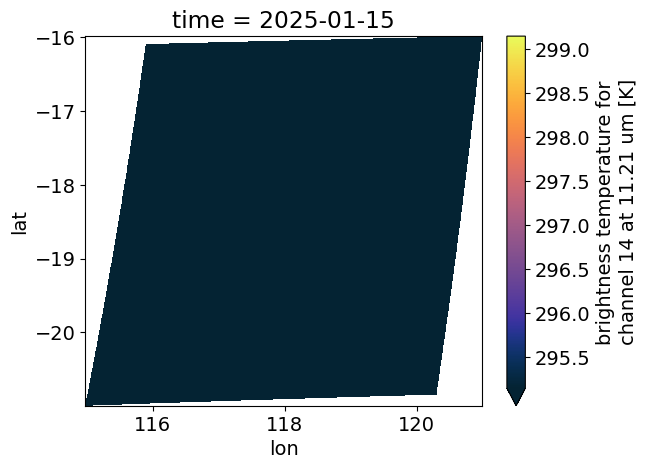

In [21]:
# plt.figure()
myds['channel_{:04d}_brightness_temperature'.format(channel)][0,...].plot(x='lon', y='lat',
            cmap=cm.cm.thermal ,                                           
            vmin=22+273.15, vmax= 26+273.15)

# Make movies of the raw data

In [22]:
import matplotlib.pyplot as plt
import cmocean as cm

var = f'channel_{channel:04d}_brightness_temperature'

def plot_frame(slab, lon2d, lat2d, fname, vmin=None, vmax=None, figsize=(8,6), dpi=120):
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    pc = ax.pcolormesh(lon2d, lat2d, slab, shading='nearest',
                       cmap=cm.cm.thermal, vmin=vmin, vmax=vmax)
    ax.set_aspect('equal')
    ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    ax.set_title(str(slab.coords['time'].values))
    cbar = fig.colorbar(pc, ax=ax, label='BT (K)')
    fig.savefig(fname, bbox_inches='tight')
    plt.close(fig)


In [23]:
import os
import numpy as np
os.makedirs('../FIGURES', exist_ok=True)

da = myds[var]               # (time, y, x)
lon2d = myds['lon'].data
lat2d = myds['lat'].data

# 只渲染前 5 帧
nframes = da.sizes['time']
for i in range(nframes):
    slab = da.isel(time=i)
    fname = f"../FIGURES/frame_{i:05d}.png"
    plot_frame(slab, lon2d, lat2d, fname, vmin=22+273.15, vmax=26+273.15)
import shutil, subprocess

ffmpeg = shutil.which("ffmpeg")
if ffmpeg is None:
    from imageio_ffmpeg import get_ffmpeg_exe
    ffmpeg = get_ffmpeg_exe()

cmd = [
    ffmpeg, "-y",
    "-framerate", "6",          # 每秒 6 帧，可自行调
    "-start_number", "0",
    "-i", "../FIGURES/frame_%05d.png",
    "-frames:v", str(nframes),  # 只取前 nframes 张
    "-c:v", "libx264",
    "-pix_fmt", "yuv420p",
    "../FIGURES/hima_test5.mp4"
]
subprocess.run(cmd, check=True)
print("36 帧小样本已合成 ../FIGURES/hima_test5.mp4")


36 帧小样本已合成 ../FIGURES/hima_test5.mp4


# Time-average and quality control

In [24]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    ds.isel(time=tt).plot(
        x='lon', y='lat',
        cmap=cm.cm.thermal,
        vmin=kwargs['vmin'], vmax=kwargs['vmax']
    )
    plt.gca().set_aspect('equal')
    return None, None

myds_1h = myds.resample(time='1H').mean()

fig=plt.figure(figsize=(8,6))
mov_custom = Movie(myds_1h['channel_{:04d}_brightness_temperature'.format(channel)], custom_plotfunc,                                          
            vmin=22+273.15, vmax= 26+273.15)

#mov_custom.save('../FIGURES/himawari_1H_{}.mp4'.format(date), progress=True)

d:\conda\envs\mnf-ningaloo\Lib\site-packages\xarray\groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


<Figure size 800x600 with 0 Axes>

In [25]:
# Mask clouds using the time derivative i.e. assume that clouds have large dT/dt relative to the ocean

T = myds['channel_{:04d}_brightness_temperature'.format(channel)].chunk({'time':-1}).load()
dTdt = T.differentiate('time', datetime_unit='s')



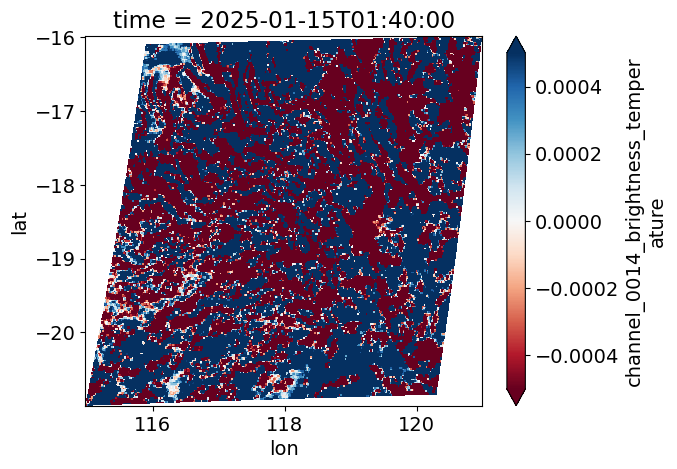

In [26]:
dTdt[10,...].plot(x='lon', y='lat',
            cmap='RdBu' ,
                vmin=-5e-4, vmax=5e-4
)

In [27]:
def custom_plotfunc2(ds, fig, tt, *args, **kwargs):
    ds.isel(time=tt).plot(x='lon', y='lat',
            cmap='RdBu', vmin=kwargs['vmin'], vmax=kwargs['vmax'] )
    plt.gca().set_aspect('equal')

    return None, None

fig=plt.figure(figsize=(8,6))
mov_custom = Movie(dTdt, custom_plotfunc2,                                          
            vmin=-5e-4, vmax=5e-4)

# mov_custom.save('../FIGURES/himawari_dTdt_{}.mp4'.format(date), progress=True)

<Figure size 800x600 with 0 Axes>

In [28]:
Tqc = T.where(np.abs(dTdt)<5e-4)


In [29]:
Tqc_1h = Tqc.resample(time='1H').mean()

d:\conda\envs\mnf-ningaloo\Lib\site-packages\xarray\groupers.py:487: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


<Figure size 800x600 with 0 Axes>

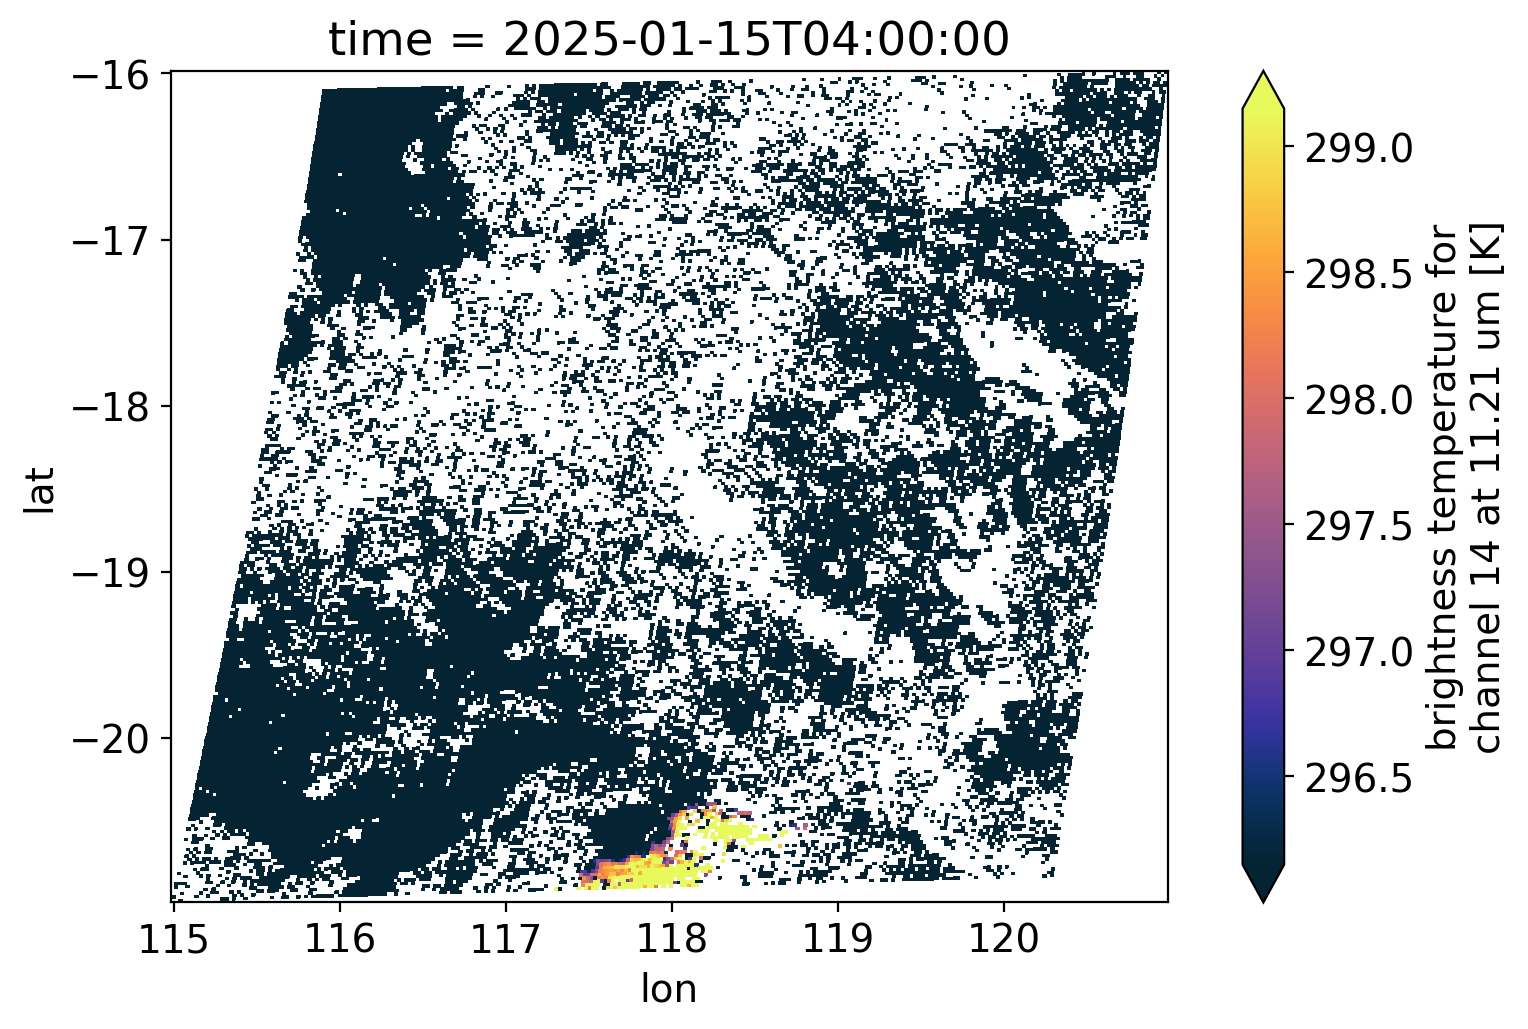

In [30]:
fig=plt.figure(figsize=(8,6))
mov_custom = Movie(Tqc_1h, custom_plotfunc,                                          
            vmin=23+273.15, vmax= 26+273.15)
mov_custom.preview(4)

In [31]:
dTdx = Tqc_1h.differentiate('x')*1e3
dTdy = Tqc_1h.differentiate('y')*1e3
dTgrad = np.abs(dTdx+1j*dTdy)

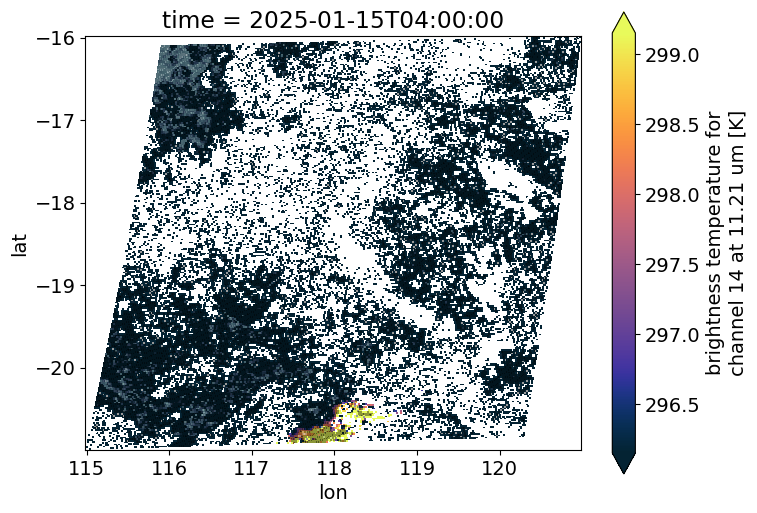

In [32]:
tt=4
fig=plt.figure(figsize=(8,6))
Tqc_1h[tt,...].plot(x='lon', y='lat',
            cmap=cm.cm.thermal,
                vmin=23+273.15, vmax= 26+273.15
)
dTgrad[tt,...].plot(x='lon', y='lat',
            cmap='bone_r' ,
                vmin=0, vmax=0.1, alpha=0.4,
                    add_colorbar=False,
)
plt.gca().set_aspect('equal')

In [33]:
dsout = xr.Dataset({'Tqc':Tqc_1h, 'dTgrad':dTgrad})
dsout

<xarray.Dataset> Size: 4MB
Dimensions:  (x: 239, y: 244, time: 7)
Coordinates:
  * x        (x) float64 2kB -2.509e+06 -2.507e+06 ... -2.035e+06 -2.033e+06
  * y        (y) float64 2kB -1.713e+06 -1.715e+06 ... -2.197e+06 -2.199e+06
    lat      (y, x) float64 467kB -16.1 -16.1 -16.1 ... -20.83 -20.83 -20.83
    lon      (y, x) float64 467kB 115.9 115.9 116.0 116.0 ... 120.2 120.3 120.3
  * time     (time) datetime64[ns] 56B 2025-01-15 ... 2025-01-15T06:00:00
Data variables:
    Tqc      (time, y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan
    dTgrad   (time, y, x) float32 2MB nan nan nan nan nan ... nan nan nan nan

In [34]:
def custom_plotfunc4(ds, fig, tt, *args, **kwargs):
    ds['Tqc'].isel(time=tt).plot(x='lon', y='lat',
            cmap=cm.cm.thermal, vmin=kwargs['vmin'], vmax=kwargs['vmax'] )
    
    ds['dTgrad'].isel(time=tt).plot(x='lon', y='lat',
             cmap='bone_r', alpha=0.4, vmin=0, vmax=0.1 , add_colorbar=False)
    

    return None, None

fig=plt.figure(figsize=(8,6))
mov_custom = Movie(dsout, custom_plotfunc4,                                          
           vmin=vmin+273.15, vmax= vmax+273.15, input_check=False)
#mov_custom.preview(12)
# mov_custom.save('../FIGURES/himawari_dTgrad_{}.mp4'.format(date), progress=True)

<Figure size 800x600 with 0 Axes>

In [35]:
pip install geopandas


Note: you may need to restart the kernel to use updated packages.


In [36]:
#import os
#import geopandas as gpd
#import xarray as xr
#from pathlib import Path

# ====== 改成你本机的真实路径 ======
#basedir = Path(r"D:\你的文件夹\MNF_SWOT\GIS")  # TODO: 这里改成实际位置

# 检查文件是否存在
#swath_shp = basedir / "SWOT_calval_Browse_overpass_swath.shp"
#nadir_shp = basedir / "SWOT_calval_Browse_overpass_nadir.shp"

#for shp in [swath_shp, nadir_shp]:
    #if not shp.exists():
        #raise FileNotFoundError(f"找不到 {shp}")

# 读取 shapefile
#swathpoly = gpd.read_file(swath_shp)
#swathline = gpd.read_file(nadir_shp)

# ====== Bathymetry 数据路径 ======
#bathy_path = os.path.expanduser('~/data/Bathymetry/GA_WEL_NWS_250m_DEM.nc')
#if not os.path.isfile(bathy_path):
    #raise FileNotFoundError(f"找不到 {bathy_path}")

# 读取 Bathy 数据
#dsZ = xr.open_dataset(bathy_path)

# 可选：调整坐标
# dsZ = dsZ.assign_coords({
#     "X": (["ny"], dsZ.Y.values),
#     "Y": (["nx"], dsZ.X.values)
# })


In [37]:
import numpy as np
import pandas as pd
import xarray as xr
import requests
from pyproj import Proj

# ===== 可改参数（若之前已定义则沿用） =====
channel = globals().get('channel', 14)

t1 = globals().get('t1', '2025-01-15 00:00:00')
t2 = globals().get('t2', '2025-01-15 06:00:00')

lon1 = globals().get('lon1', 115.0); lon2 = globals().get('lon2', 121.0)
lat1 = globals().get('lat1', -21.0); lat2 = globals().get('lat2', -16.0)
# =====================================

# 1) 生成 arc 档案 URL 并检测可用性（10 分钟分辨率）
def get_himawari9_url_arc(band, yyyy, mm, dd, hhmm):
    yyyy = f"{int(yyyy):04d}"; mm = f"{int(mm):02d}"; dd = f"{int(dd):02d}"; hhmm = f"{int(hhmm):04d}"
    base = "https://thredds.nci.org.au/thredds/dodsC/ra22/satellite-products/arc/obs/himawari-ahi/fldk/v1-0/"
    fname = f"{yyyy}{mm}{dd}{hhmm}00-P1S-ABOM_OBS_B{band}-PRJ_GEOS141_2000-HIMAWARI9-AHI.nc"
    return f"{base}{yyyy}/{mm}/{dd}/{hhmm}/{fname}"

def ok_dds(url):
    try:
        r = requests.get(url + ".dds", timeout=20, allow_redirects=False)
        return r.status_code == 200
    except Exception:
        return False

if 'goodurl' not in globals() or len(globals().get('goodurl', [])) == 0:
    times = pd.date_range(t1, t2, freq='600s')
    urls = [ get_himawari9_url_arc(channel, tt.year, f"{tt.month:02d}", f"{tt.day:02d}", f"{tt.hour:02d}{tt.minute:02d}") for tt in times ]
    goodurl = [u for u in urls if ok_dds(u)]
    print("可用文件数：", len(goodurl))
    if len(goodurl) == 0:
        raise RuntimeError("没有可用文件，请检查时间窗/通道或网络访问。")

# 2) 打开多文件数据集
dsmf = xr.open_mfdataset(goodurl, combine='nested', concat_dim='time')

# 3) 构建投影并算出研究区域子集索引
#    有的文件 grid-mapping 在变量 geostationary.proj4
try:
    P = Proj(dsmf.geostationary.proj4)
except Exception:
    # 兼容某些版本：从变量属性拿 proj4_str / crs_wkt（按需扩展）
    P = Proj("+proj=geos +h=35785831 +lon_0=140.7 +sweep=x +a=6378137 +b=6356752.31414 +units=m +no_defs")

X, Y = np.meshgrid(dsmf.x.values, dsmf.y.values)
x1, y1 = P(lon1, lat1); x2, y2 = P(lon2, lat2)

def find_nearest_idx(xx, yy, xp, yp):
    # 返回 (j, i)
    j = np.abs(yy[:,0] - yp).argmin()
    i = np.abs(xx[0,:] - xp).argmin()
    return j, i

J1, I1 = find_nearest_idx(X, Y, x1, y1)
J2, I2 = find_nearest_idx(X, Y, x2, y2)

# 确保切片方向正确
jmin, jmax = sorted([J1, J2])
imin, imax = sorted([I1, I2])

# 4) 子集 + 计算该子集的经纬度 2D 网格并挂到 coords
sub = dsmf.isel(x=slice(imin, imax), y=slice(jmin, jmax))
x_sub = X[jmin:jmax, imin:imax]; y_sub = Y[jmin:jmax, imin:imax]
lon_sub, lat_sub = P(x_sub, y_sub, inverse=True)

myds = sub.assign_coords({
    "lon": (("y","x"), lon_sub),
    "lat": (("y","x"), lat_sub),
})

print(myds)


<xarray.Dataset> Size: 9MB
Dimensions:                              (time: 36, y: 244, x: 239)
Coordinates:
  * time                                 (time) datetime64[ns] 288B 2025-01-1...
  * x                                    (x) float64 2kB -2.509e+06 ... -2.03...
  * y                                    (y) float64 2kB -1.713e+06 ... -2.19...
    lon                                  (y, x) float64 467kB 115.9 ... 120.3
    lat                                  (y, x) float64 467kB -16.1 ... -20.83
Data variables:
    geostationary                        (time) float32 144B 9.969e+36 ... 9....
    scan_line_time                       (time, y) datetime64[ns] 70kB dask.array<chunksize=(1, 244), meta=np.ndarray>
    channel_0014_brightness_temperature  (time, y, x) float32 8MB dask.array<chunksize=(1, 244, 239), meta=np.ndarray>
Attributes: (12/60)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:      

In [38]:
# ========= 36 帧小样本：预处理 + 两步法合成（不重采样，保36帧） =========
import os, glob, shutil, subprocess
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm

# ---- 可调参数 ----
channel   = globals().get('channel', 14)
lon1      = globals().get('lon1', 115.0); lon2 = globals().get('lon2', 121.0)
lat1      = globals().get('lat1', -21.0); lat2 = globals().get('lat2', -16.0)
outdir    = "../FIGURES"
basename  = "demo_36frames"
framerate = 6
first_n   = 36               # 需要 36 帧
keep_png  = False

# 色标
bt_vmin, bt_vmax     = 22+273.15, 26+273.15
grad_vmin, grad_vmax = 0.0, 0.1

# ---- 1) 取前 36 帧做预处理（不重采样）----
assert 'myds' in globals(), "myds 未定义，请先构建 myds。"
varname = f"channel_{channel:04d}_brightness_temperature"
assert varname in myds.data_vars, f"{varname} 不在 myds 中。"

# 取前 36 帧
mys = myds.isel(time=slice(0, 36))
T   = mys[varname].load()

# 云质控
dTdt = T.differentiate("time", datetime_unit="s")
Tqc  = T.where(np.abs(dTdt) < 5e-4)

# 不做重采样，直接保持原时间分辨率，确保帧数
Tqc_rs = Tqc

# 水平梯度（K/km）
dTdx   = Tqc_rs.differentiate("x") * 1e3
dTdy   = Tqc_rs.differentiate("y") * 1e3
dTgrad = np.abs(dTdx + 1j*dTdy)

# 组装输出数据集
dsout = xr.Dataset({"Tqc": Tqc_rs, "dTgrad": dTgrad}) \
          .assign_coords({"lon": mys["lon"], "lat": mys["lat"]})

nt = int(dsout.sizes.get("time", 0))
assert nt >= 36, f"前 36 帧不足（当前只有 {nt} 帧）。请扩大 slice 或检查输入数据。"
print(dsout)

# ---- 2) 两步法：先出帧，再 ffmpeg 合成 ----
os.makedirs(outdir, exist_ok=True)
tmp_dir = os.path.join(outdir, "tmp_frames_36")
os.makedirs(tmp_dir, exist_ok=True)

# 清理旧帧
for f in glob.glob(os.path.join(tmp_dir, "frame_*.png")):
    try: os.remove(f)
    except: pass

def plot_frame(dsout, t_index, fname):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=110)
    dsout["Tqc"].isel(time=t_index).plot(
        x="lon", y="lat", ax=ax,
        cmap=cm.cm.thermal, vmin=bt_vmin, vmax=bt_vmax
    )
    dsout["dTgrad"].isel(time=t_index).plot(
        x="lon", y="lat", ax=ax,
        cmap="bone_r", alpha=0.4, vmin=grad_vmin, vmax=grad_vmax, add_colorbar=False
    )
    ax.set_xlim(lon1, lon2); ax.set_ylim(lat1, lat2); ax.set_aspect("equal")
    ax.set_title(str(dsout["Tqc"].coords["time"].isel(time=t_index).values))
    fig.savefig(fname, bbox_inches="tight"); plt.close(fig)

# 固定画 36 帧
nframes = 36
print(f"[frames] 准备绘制 {nframes}/{nt} 帧")
for i in range(nframes):
    plot_frame(dsout, i, os.path.join(tmp_dir, f"frame_{i:05d}.png"))

# ffmpeg 合成
ffmpeg = shutil.which("ffmpeg")
if ffmpeg is None:
    from imageio_ffmpeg import get_ffmpeg_exe
    ffmpeg = get_ffmpeg_exe()

mp4_path = os.path.join(outdir, f"{basename}.mp4")
subprocess.run([
    ffmpeg, "-y",
    "-framerate", str(framerate),
    "-i", os.path.join(tmp_dir, "frame_%05d.png"),
    "-c:v", "libx264", "-preset", "veryfast", "-crf", "22",
    "-pix_fmt", "yuv420p",
    mp4_path
], check=True)

print("[OK] 36 帧视频已生成：", mp4_path)

if not keep_png:
    shutil.rmtree(tmp_dir)
    print("[INFO] PNG 已删除")


<xarray.Dataset> Size: 18MB
Dimensions:  (time: 36, x: 239, y: 244)
Coordinates:
  * time     (time) datetime64[ns] 288B 2025-01-15 ... 2025-01-15T06:00:00
  * x        (x) float64 2kB -2.509e+06 -2.507e+06 ... -2.035e+06 -2.033e+06
  * y        (y) float64 2kB -1.713e+06 -1.715e+06 ... -2.197e+06 -2.199e+06
    lon      (y, x) float64 467kB 115.9 115.9 116.0 116.0 ... 120.2 120.3 120.3
    lat      (y, x) float64 467kB -16.1 -16.1 -16.1 ... -20.83 -20.83 -20.83
Data variables:
    Tqc      (time, y, x) float32 8MB nan nan nan nan nan ... nan nan nan nan
    dTgrad   (time, y, x) float32 8MB nan nan nan nan nan ... nan nan nan nan
[frames] 准备绘制 36/36 帧
[OK] 36 帧视频已生成： ../FIGURES\demo_36frames.mp4
[INFO] PNG 已删除
